In [1]:
import numpy as np
import gurobipy as gbp
import time
import pandas as pd
np.random.seed(352)


# Commodity

ppe: 80 (36*2 + 8)
ventilators: 1*0.7/person/day
oxy: 4/person/day 
hcq: 3/p/d
paracetamol: 5/p/d
syringes: 68/p/d
infusion_pump: 2.5/p/d

Delhi cases: 3600 per day(critical). 

Total pateint -> 72,000
5% ICU =3600 , 15% ACU, 80% SCU

1. 70% of ICU require ventilator -> 3600*70% = 2520
2. Infusion pump -> 9000
3. Sanitizer -> 3600
4. HCQ -> 10,800
5. Oxygen -> 14,400*

In [2]:
n_com=4 #no of commodities
n_sup=2 #no of supply nodes
n_dem=3 #no of demands nodes

In [46]:
#Supply Demand of all commodities 
"""[
[Day1:[Supplier_1:comm1,Supplier_1:comm2],[s2c1,s2c2]],
Day2:[],
Day3:[]
    ]"""

Si=np.array([[[700,2500,7000,5000],[400,2500,3000,4000]],
             [[1000,6000,10000,11000],[500,4000,6000,4000]],
             [[1500,6000,30000,13000],[1000,4000,10000,7000]]])
Dj=np.array([[[800,1100,5000,4000],[500,700,3000,2000],[1200,1800,7000,5000]],
             [[1200,1500, 6000,5000],[800,500,5000,5000],[2000,4000,12000,8000]],
             [[2000,4000, 10000, 6000],[1000,10000, 6000, 4000],[4000,4000,20000, 17000]]])
Si.shape,Dj.shape #days X nodes X commodities

((3, 2, 4), (3, 3, 4))

In [47]:
# Si,Dj=Si*7,Dj*7
# Si,Dj

In [48]:
# check assumption that demand is always higher than supply
np.sum(Si,axis=1)<np.sum(Dj,axis=1)

array([[ True, False,  True,  True],
       [ True, False,  True,  True],
       [ True,  True, False,  True]])

In [49]:
#Vehicle capacity, number of vehicles with each supplier, cost of transportation from supply nodes to demand nodes
V_cap=3000
V_num=np.array([15,20])
V_cost=np.array([[10,15,20],[18,13,20]])*100

In [50]:
V_cost

array([[1000, 1500, 2000],
       [1800, 1300, 2000]])

In [51]:
np.sum(Si,axis=2)

array([[15200,  9900],
       [28000, 14500],
       [50500, 22000]])

In [52]:
np.sum(Si,axis=2)<[[V_cap*V_num]*3]

array([[[ True,  True],
        [ True,  True],
        [False,  True]]])

In [53]:
#People Variables
n_pep=np.array([[[1000,1000,1000,1000],[800,800,800,800],[1800,1800,1800,1800]],
                [[2200,2200,2200,2200],[1100,1100,1100,1100],[2400,2400,2400,2400]],
                [[3000,3000,3000,3000],[1900,1900,1900,1900],[4100,4100,4100,4100]]])
# n_pep=np.array([[[25,25],[50,50],[30,30]],
#                 [[25,25],[50,50],[30,30]],
#                 [[25,25],[50,50],[30,30]]]) #no of people on each demand node,
mu=[0.7,1,4,3] #consumption rate (comm req per person per day)
pc=[0.8,0.2,0.5,1.0]

In [54]:
np.sum(n_pep,axis=1)

array([[3600, 3600, 3600, 3600],
       [5700, 5700, 5700, 5700],
       [9000, 9000, 9000, 9000]])

In [55]:
n_days=len(Si)
days_range=range(n_days)
days_range

range(0, 3)

In [56]:
# Indices & Variable Names
supply_nodes = n_sup
demand_nodes = n_dem
supply_nodes_range = range(n_sup)
demand_nodes_range = range(n_dem)
comm_range=range(n_com)
all_nodes_len = n_sup*n_dem
ALL_nodes_range = range(all_nodes_len)

print (supply_nodes_range, demand_nodes_range,comm_range, all_nodes_len)

range(0, 2) range(0, 3) range(0, 4) 6


In [57]:
Pc=np.array([Dj[ix]/Dj[ix].sum(axis=0) for ix in range(len(Dj))])
Pc=Pc*pc
Pc

array([[[0.256     , 0.06111111, 0.16666667, 0.36363636],
        [0.16      , 0.03888889, 0.1       , 0.18181818],
        [0.384     , 0.1       , 0.23333333, 0.45454545]],

       [[0.24      , 0.05      , 0.13043478, 0.27777778],
        [0.16      , 0.01666667, 0.10869565, 0.27777778],
        [0.4       , 0.13333333, 0.26086957, 0.44444444]],

       [[0.22857143, 0.04444444, 0.13888889, 0.22222222],
        [0.11428571, 0.11111111, 0.08333333, 0.14814815],
        [0.45714286, 0.04444444, 0.27777778, 0.62962963]]])

In [58]:
dep_time=24
dep_cost=np.exp(1.5031+0.1172*dep_time)-np.exp(1.5031)
dep_cost

70.38538215041021

In [188]:
unserved_people=[[[0,0,0,0],[0,0,0,0],[0,0,0,0]]]
prev_inventory=[Si[0]*0]
unserved_people,prev_inventory
cols=['Day','S_Node']+['D'+str(i+1)+'_c'+str(j+1) for i in demand_nodes_range for j in comm_range]
cols+=['Total_S_c'+str(i+1) for i in comm_range]
cols+=['Deliver_S_c'+str(i+1) for i in comm_range]
cols+=['D'+str(i+1)+'_v' for i in demand_nodes_range]
cols+=['Total_V']

df=pd.DataFrame(columns=cols,index=None,dtype=int)

cols2=['Day','D_Node']+['Total'+'_c'+str(i+1) for i in comm_range]+['Unserv'+'_c'+str(i+1) for i in comm_range]
df2=pd.DataFrame(columns=cols2,index=None,dtype=int)
df2

# unserved_people=[[[0,0],[0,0],[0,0]]]
for day in days_range:
    print ('#'*50,'  Day',day+1,'  ','#'*50)
    # Create Model, Set MIP Focus, Add Variables, & Update Model
    m = gbp.Model(' -- The Multi Commodity Vehicle Transportation Problem -- ')

    # Set MIP Focus to 2 for optimality
    m.setParam('MIPFocus', 2)
    # m.setParam(gbp.GRB.Param.PoolSearchMode, 1)
    # m.setParam(gbp.GRB.Param.PoolGap, 0.10)

    decision_var = []
    vehicles_var=[]
    unserved_var=[]
    for orig in supply_nodes_range:
        decision_var.append([])
        vehicles_var.append([])
        for dest in demand_nodes_range:
            decision_var[orig].append([])
            vehicles_var[orig].append(m.addVar(vtype=gbp.GRB.INTEGER,
                                              name='S'+str(orig+1)+'_D'+str(dest+1)+'_V'))
            for comm in comm_range:
    #             print (comm,decision_var)
                decision_var[orig][dest].append(m.addVar(vtype=gbp.GRB.INTEGER, 
    #                                         obj=Cij[orig][dest],
    #                                            obj=1,
                                            name='S'+str(orig+1)+'_D'+str(dest+1)+'_c'+str(comm+1)))
    for dest in demand_nodes_range:
        unserved_var.append([])
        for comm in comm_range:
            unserved_var[dest].append(m.addVar(vtype=gbp.GRB.INTEGER,
                                              name='D'+str(dest+1)+'_c'+str(comm+1)+'_U'))
            
########     Update Model Variables
    m.update() 
    
    #sum(sum[(Demand - net supplied)*priority for every demand node] for every commodity)
    first_term=10*gbp.quicksum(gbp.quicksum((int(Dj[day][dest][comm])-gbp.quicksum(decision_var[orig][dest][comm] for orig in supply_nodes_range))*(Pc[day][dest][comm])
                                for dest in demand_nodes_range) for comm in comm_range)
    print ('First term: ',first_term)
    
    second_term=0.01*gbp.quicksum(gbp.quicksum(vehicles_var[orig][dest]*V_cost[orig][dest] for dest in demand_nodes_range) for orig in supply_nodes_range)
    third_term=0.1*gbp.quicksum(gbp.quicksum(unserved_var[dest][comm]*dep_cost*(1/pc[comm]) for comm in comm_range) for dest in demand_nodes_range)
#     third_term=0.1*gbp.quicksum(gbp.quicksum(unserved_var[dest][comm] for comm in comm_range) for dest in demand_nodes_range)
    
    #objective function
    m.setObjective(first_term+second_term+third_term,gbp.GRB.MINIMIZE)

    m.update()

##########     Add Supply Constraints

    #sum(net supplied) <= available supply + previous inventory
    for orig in supply_nodes_range:
        for comm in comm_range:
            m.addConstr(gbp.quicksum(decision_var[orig][dest][comm]
                                     for dest in demand_nodes_range) - Si[day][orig][comm] - prev_inventory[day][orig][comm] <= 0)
            
########     Add Demand Constraints
    #sum(supplied commodity at demand node) <= demand that day
    for dest in demand_nodes_range:  
        for comm in comm_range:
            m.addConstr(gbp.quicksum(decision_var[orig][dest][comm] 
                                     for orig in supply_nodes_range) - Dj[day][dest][comm] <= 0)
            
###########     Add vehicle constraints

#     for orig in supply_nodes_range:
#         m.addConstr(gbp.quicksum(decision_var[orig][dest][comm]
#                                  for dest in demand_nodes_range for comm in comm_range) - V_cap*V_num[orig] <=0)

    #total sent vehicles at demand nodes <= available vehicles
    for orig in supply_nodes_range:
        m.addConstr(gbp.quicksum(vehicles_var[orig][dest] for dest in demand_nodes_range) - V_num[orig] <=0)
    
    #vehicles sent to a demand node >= (total supplied items to that node / vehicle capacity) 
    for orig in supply_nodes_range:
        for dest in demand_nodes_range:
            m.addConstr(-sum(decision_var[orig][dest][comm]
                                for comm in comm_range)/V_cap + vehicles_var[orig][dest]>=0)
            
    # vehicles sent to a demand node-1 <= (total supplied items to that node / vehicle capacity)
    for orig in supply_nodes_range:
        for dest in demand_nodes_range:
            m.addConstr(-sum(decision_var[orig][dest][comm]
                                for comm in comm_range)/V_cap + vehicles_var[orig][dest]<=1)

            
######     Add unserved people contstraints
    #unserved people at t <= num of people at t + unserved people at t-1
    for dest in demand_nodes_range:
        for comm in comm_range:
#             print (dest,comm,day,np.array(unserved_var).shape,np.array(n_pep).shape,np.array(unserved_people).shape)
#             print (unserved_var[dest][comm])
#             print (n_pep[day][dest][comm])
#             print (unserved_people[day][dest][comm])
            m.addConstr(unserved_var[dest][comm]<=n_pep[day][dest][comm]+unserved_people[day][dest][comm])
            
    # supplied commodity at demand node > (no of people at t + unserved people at t-1 - unserved people at t)*consumption rate
    for dest in demand_nodes_range:
        for comm in comm_range:
            m.addConstr(sum(decision_var[orig][dest][comm] for orig in supply_nodes_range)-
                        ((n_pep[day][dest][comm]+unserved_people[day][dest][comm]-unserved_var[dest][comm])*mu[comm])>=0)
            
        
#      Adding 0 inventory for next day constraint: no supply left for t+1
#     for orig in supply_nodes_range:
#         for comm in comm_range:
#             m.addConstr(gbp.quicksum(decision_var[orig][dest][comm]
#                                      for dest in demand_nodes_range) - Si[day][orig][comm] >= 0)

    #  Optimize and Print( Results)
    m.optimize()
    m.write('./path.lp')
#     print (m.display())

#     m.display()
    prev_inventory.append([])

    #todays supply + previous inventory - net supplied = todays inventory
    for orig in supply_nodes_range:
        prev_inventory[day+1].append([])
        for comm in comm_range:
            prev_inventory[day+1][orig].append(Si[day][orig][comm]+prev_inventory[day][orig][comm]-sum(decision_var[orig][dest][comm].x
                                 for dest in demand_nodes_range))

#     print (prev_inventory)
    unserved_people.append([])
    for dest in demand_nodes_range:
        unserved_people[day+1].append([])
        for comm in comm_range:
            unserved_people[day+1][dest].append(unserved_var[dest][comm].x)

            
    
    #Populate DataFrame
    for ix in supply_nodes_range:
        r_t=[]
        r_t+=[decision_var[ix][iy][iz].x for iy in demand_nodes_range for iz in comm_range]
        r_t+=[Si[day][ix][iy] for iy in comm_range]
        r_t+=[sum(decision_var[ix][iy][iz].x for iy in demand_nodes_range) for iz in comm_range]
        r_t+=[vehicles_var[ix][iy].x for iy in demand_nodes_range]
        r_t+=[V_num[ix]]
        df.loc[len(df)]=[day+1,ix+1]+r_t

    for ix in demand_nodes_range:
        r_t=[]
        r_t+=[n_pep[day][ix][iy]+unserved_people[day][ix][iy] for iy in comm_range]
        r_t+=[unserved_var[ix][iy].x for iy in comm_range]
        df2.loc[len(df2)]=[day+1,int(ix+1)]+r_t
    
    first_term_val=sum(sum((int(Dj[day][dest][comm])-sum(decision_var[orig][dest][comm].x for orig in supply_nodes_range))*(Pc[day][dest][comm])
                                for dest in demand_nodes_range) for comm in comm_range)
    second_term_val=0.01*sum(sum(vehicles_var[orig][dest].x*V_cost[orig][dest] for dest in demand_nodes_range) for orig in supply_nodes_range)
    third_term_val=0.1*sum(sum(unserved_var[dest][comm].x*dep_cost for comm in comm_range) for dest in demand_nodes_range)
    
    print ('^'*100)
    print ("First term: ",int(first_term_val)," Second term: ",int(second_term_val)," Third term: ",int(third_term_val))
    print ('^'*100)


##################################################   Day 1    ##################################################
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
First term:  <gurobi.LinExpr: 78776.20202020202 + -2.56 S1_D1_c1 + -2.56 S2_D1_c1 + -1.6000000000000003 S1_D2_c1 + -1.6000000000000003 S2_D2_c1 + -3.84 S1_D3_c1 + -3.84 S2_D3_c1 + -0.6111111111111112 S1_D1_c2 + -0.6111111111111112 S2_D1_c2 + -0.3888888888888889 S1_D2_c2 + -0.3888888888888889 S2_D2_c2 + -1.0 S1_D3_c2 + -1.0 S2_D3_c2 + -1.6666666666666665 S1_D1_c3 + -1.6666666666666665 S2_D1_c3 + -1.0 S1_D2_c3 + -1.0 S2_D2_c3 + -2.3333333333333335 S1_D3_c3 + -2.3333333333333335 S2_D3_c3 + -3.6363636363636367 S1_D1_c4 + -3.6363636363636367 S2_D1_c4 + -1.8181818181818183 S1_D2_c4 + -1.8181818181818183 S2_D2_c4 + -4.545454545454545 S1_D3_c4 + -4.545454545454545 S2_D3_c4>
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 58 rows, 42 columns and 162 nonzeros
Model fingerprint:

In [60]:
prev_inventory

[array([[0, 0, 0, 0],
        [0, 0, 0, 0]]),
 [[0.0, 300.0, 0.0, 0.0], [0.0, 1200.0, 0.0, 0.0]],
 [[0.0, 4800.0, 0.0, 0.0], [0.0, 701.0, 0.0, 0.0]],
 [[0.0, 4801.0, 5500.0, 0.0], [0.0, 0.0, 0.0, 0.0]]]

In [71]:
unserved_people

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[1000.0, -0.0, 250.0, -0.0],
  [800.0, 100.0, 800.0, 467.0],
  [229.0, -0.0, 50.0, 134.0]],
 [[3200.0, 700.0, 950.0, 700.0],
  [1900.0, 700.0, 1850.0, 601.0],
  [487.0, -0.0, -0.0, -0.0]],
 [[6200.0, -0.0, 1450.0, 2700.0],
  [3800.0, -0.0, 2250.0, 2501.0],
  [1016.0, 100.0, -0.0, -0.0]]]

In [72]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [63]:
df #without deprivation priority

,Day,S_Node,D1_c1,D1_c2,D1_c3,D1_c4,D2_c1,D2_c2,D2_c3,D2_c4,D3_c1,D3_c2,D3_c3,D3_c4,Total_S_c1,Total_S_c2,Total_S_c3,Total_S_c4,Deliver_S_c1,Deliver_S_c2,Deliver_S_c3,Deliver_S_c4,D1_v,D2_v,D3_v,Total_V
0,1.0,1.0,-0.0,1000.0,2000.0,3000.0,-0.0,-0.0,-0.0,-0.0,700.0,1200.0,5000.0,2000.0,700.0,2500.0,7000.0,5000.0,700.0,2200.0,7000.0,5000.0,2.0,-0.0,3.0,15.0
1,1.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0,700.0,1000.0,1000.0,400.0,600.0,2000.0,3000.0,400.0,2500.0,3000.0,4000.0,400.0,1300.0,3000.0,4000.0,-0.0,1.0,2.0,20.0
2,2.0,1.0,0.0,1500.0,5600.0,4897.0,0.0,0.0,0.0,0.0,1000.0,0.0,4400.0,6103.0,1000.0,6000.0,10000.0,11000.0,1000.0,1500.0,10000.0,11000.0,4.0,0.0,4.0,15.0
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,2499.0,500.0,3999.0,6000.0,1501.0,500.0,4000.0,6000.0,4000.0,500.0,4499.0,6000.0,4000.0,0.0,1.0,4.0,20.0
4,3.0,1.0,0.0,1999.0,10000.0,3000.0,0.0,0.0,0.0,0.0,1500.0,4000.0,14500.0,10000.0,1500.0,6000.0,30000.0,13000.0,1500.0,5999.0,24500.0,13000.0,5.0,0.0,10.0,15.0
5,3.0,2.0,0.0,1701.0,0.0,0.0,0.0,3000.0,6000.0,0.0,1000.0,0.0,4000.0,7000.0,1000.0,4000.0,10000.0,7000.0,1000.0,4701.0,10000.0,7000.0,1.0,3.0,4.0,20.0


In [73]:
df #actual (with priority on deprivation)

,Day,S_Node,D1_c1,D1_c2,D1_c3,D1_c4,D2_c1,D2_c2,D2_c3,D2_c4,D3_c1,D3_c2,D3_c3,D3_c4,Total_S_c1,Total_S_c2,Total_S_c3,Total_S_c4,Deliver_S_c1,Deliver_S_c2,Deliver_S_c3,Deliver_S_c4,D1_v,D2_v,D3_v,Total_V
0,1.0,1.0,0.0,1100.0,3000.0,3001.0,0.0,700.0,0.0,999.0,700.0,300.0,4000.0,1000.0,700.0,2500.0,7000.0,5000.0,700.0,2100.0,7000.0,5000.0,3.0,1.0,2.0,15.0
1,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,1500.0,3000.0,4000.0,400.0,2500.0,3000.0,4000.0,400.0,1500.0,3000.0,4000.0,0.0,0.0,3.0,20.0
2,2.0,1.0,-0.0,1500.0,6000.0,4500.0,-0.0,-0.0,-0.0,-0.0,1000.0,3271.0,4000.0,6500.0,1000.0,6000.0,10000.0,11000.0,1000.0,4771.0,10000.0,11000.0,4.0,-0.0,5.0,15.0
3,2.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0,500.0,200.0,2898.0,500.0,729.0,5800.0,1102.0,500.0,4000.0,6000.0,4000.0,500.0,1229.0,6000.0,4000.0,-0.0,2.0,3.0,20.0
4,3.0,1.0,0.0,3700.0,10000.0,1300.0,-0.0,0.0,-0.0,-0.0,1500.0,800.0,16000.0,11700.0,1500.0,6000.0,30000.0,13000.0,1500.0,4500.0,26000.0,13000.0,5.0,0.0,10.0,15.0
5,3.0,2.0,-0.0,-0.0,0.0,1700.0,-0.0,4571.0,6000.0,-0.0,1000.0,3200.0,4000.0,5300.0,1000.0,4000.0,10000.0,7000.0,1000.0,7771.0,10000.0,7000.0,1.0,4.0,5.0,20.0


In [189]:
df #without 3rd term(deprivation)

,Day,S_Node,D1_c1,D1_c2,D1_c3,D1_c4,D2_c1,D2_c2,D2_c3,D2_c4,D3_c1,D3_c2,D3_c3,D3_c4,Total_S_c1,Total_S_c2,Total_S_c3,Total_S_c4,Deliver_S_c1,Deliver_S_c2,Deliver_S_c3,Deliver_S_c4,D1_v,D2_v,D3_v,Total_V
0,1.0,1.0,0.0,1100.0,3000.0,4000.0,0.0,0.0,0.0,0.0,700.0,200.0,4000.0,1000.0,700.0,2500.0,7000.0,5000.0,700.0,1300.0,7000.0,5000.0,3.0,0.0,2.0,15.0
1,1.0,2.0,0.0,-0.0,-0.0,-0.0,0.0,700.0,0.0,0.0,400.0,1600.0,3000.0,4000.0,400.0,2500.0,3000.0,4000.0,400.0,2300.0,3000.0,4000.0,-0.0,1.0,3.0,20.0
2,2.0,1.0,-0.0,1500.0,4000.0,4998.0,-0.0,0.0,-0.0,-0.0,1000.0,4000.0,6000.0,6002.0,1000.0,6000.0,10000.0,11000.0,1000.0,5500.0,10000.0,11000.0,4.0,0.0,6.0,15.0
3,2.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0,500.0,-0.0,2002.0,500.0,-0.0,6000.0,1998.0,500.0,4000.0,6000.0,4000.0,500.0,500.0,6000.0,4000.0,0.0,1.0,3.0,20.0
4,3.0,1.0,0.0,2000.0,10000.0,3000.0,-0.0,2500.0,500.0,-0.0,1500.0,-0.0,15500.0,10000.0,1500.0,6000.0,30000.0,13000.0,1500.0,4500.0,26000.0,13000.0,5.0,1.0,9.0,15.0
5,3.0,2.0,-0.0,-0.0,-0.0,-0.0,-0.0,7500.0,5500.0,-0.0,1000.0,200.0,4500.0,7000.0,1000.0,4000.0,10000.0,7000.0,1000.0,7700.0,10000.0,7000.0,0.0,5.0,5.0,20.0


In [64]:
df2

,Day,D_Node,Total_c1,Total_c2,Total_c3,Total_c4,Unserv_c1,Unserv_c2,Unserv_c3,Unserv_c4
0,1.0,1.0,1000.0,1000.0,1000.0,1000.0,1000.0,-0.0,500.0,-0.0
1,1.0,2.0,800.0,800.0,800.0,800.0,800.0,100.0,550.0,467.0
2,1.0,3.0,1800.0,1800.0,1800.0,1800.0,229.0,-0.0,50.0,134.0
3,2.0,1.0,3200.0,2200.0,2700.0,2200.0,3200.0,700.0,1300.0,568.0
4,2.0,2.0,1900.0,1200.0,1650.0,1567.0,1900.0,700.0,1650.0,734.0
5,2.0,3.0,2629.0,2400.0,2450.0,2534.0,487.0,-0.0,-0.0,-0.0
6,3.0,1.0,6200.0,3700.0,4300.0,3568.0,6200.0,-0.0,1800.0,2568.0
7,3.0,2.0,3800.0,2600.0,3550.0,2634.0,3800.0,-0.0,2050.0,2634.0
8,3.0,3.0,4587.0,4100.0,4100.0,4100.0,1016.0,100.0,-0.0,-0.0


In [74]:
df2

,Day,D_Node,Total_c1,Total_c2,Total_c3,Total_c4,Unserv_c1,Unserv_c2,Unserv_c3,Unserv_c4
0,1.0,1.0,1000.0,1000.0,1000.0,1000.0,1000.0,-0.0,250.0,-0.0
1,1.0,2.0,800.0,800.0,800.0,800.0,800.0,100.0,800.0,467.0
2,1.0,3.0,1800.0,1800.0,1800.0,1800.0,229.0,-0.0,50.0,134.0
3,2.0,1.0,3200.0,2200.0,2450.0,2200.0,3200.0,700.0,950.0,700.0
4,2.0,2.0,1900.0,1200.0,1900.0,1567.0,1900.0,700.0,1850.0,601.0
5,2.0,3.0,2629.0,2400.0,2450.0,2534.0,487.0,-0.0,-0.0,-0.0
6,3.0,1.0,6200.0,3700.0,3950.0,3700.0,6200.0,-0.0,1450.0,2700.0
7,3.0,2.0,3800.0,2600.0,3750.0,2501.0,3800.0,-0.0,2250.0,2501.0
8,3.0,3.0,4587.0,4100.0,4100.0,4100.0,1016.0,100.0,-0.0,-0.0


In [190]:
df2

,Day,D_Node,Total_c1,Total_c2,Total_c3,Total_c4,Unserv_c1,Unserv_c2,Unserv_c3,Unserv_c4
0,1.0,1.0,1000.0,1000.0,1000.0,1000.0,1000.0,0.0,250.0,-0.0
1,1.0,2.0,800.0,800.0,800.0,800.0,800.0,100.0,800.0,800.0
2,1.0,3.0,1800.0,1800.0,1800.0,1800.0,229.0,-0.0,50.0,134.0
3,2.0,1.0,3200.0,2200.0,2450.0,2200.0,3200.0,700.0,1450.0,534.0
4,2.0,2.0,1900.0,1200.0,1900.0,1900.0,1900.0,700.0,1900.0,1233.0
5,2.0,3.0,2629.0,2400.0,2450.0,2534.0,487.0,-0.0,-0.0,-0.0
6,3.0,1.0,6200.0,3700.0,4450.0,3534.0,6200.0,1700.0,1950.0,2534.0
7,3.0,2.0,3800.0,2600.0,3800.0,3133.0,3800.0,-0.0,2300.0,3133.0
8,3.0,3.0,4587.0,4100.0,4100.0,4100.0,1016.0,3900.0,-0.0,-0.0


In [65]:
n_pep

array([[[1000, 1000, 1000, 1000],
        [ 800,  800,  800,  800],
        [1800, 1800, 1800, 1800]],

       [[2200, 2200, 2200, 2200],
        [1100, 1100, 1100, 1100],
        [2400, 2400, 2400, 2400]],

       [[3000, 3000, 3000, 3000],
        [1900, 1900, 1900, 1900],
        [4100, 4100, 4100, 4100]]])

In [67]:
Dj

array([[[  800,  1100,  5000,  4000],
        [  500,   700,  3000,  2000],
        [ 1200,  1800,  7000,  5000]],

       [[ 1200,  1500,  6000,  5000],
        [  800,   500,  5000,  5000],
        [ 2000,  4000, 12000,  8000]],

       [[ 2000,  4000, 10000,  6000],
        [ 1000, 10000,  6000,  4000],
        [ 4000,  4000, 20000, 17000]]])

In [162]:
np.sum(Si,axis=1)

array([[ 1100,  5000, 10000,  9000],
       [ 1500, 10000, 16000, 15000],
       [ 2500, 10000, 40000, 20000]])

In [135]:
from matplotlib import pyplot as plt

In [136]:
x1=df2['Total_c1'].values-df2['Unserv_c1'].values
x2=df2['Total_c2'].values-df2['Unserv_c2'].values
x3=df2['Total_c3'].values-df2['Unserv_c3'].values
x4=df2['Total_c4'].values-df2['Unserv_c4'].values

In [144]:
# y=['Day-1','Day-2',"Day-3"]
# plt.bar(y,np.sum(x.reshape(-1,3),axis=1), color ='blue',  
#         width = barWidth,label='C1')

In [138]:
barWidth=0.15
br1 = np.arange(len(x1[::3])) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

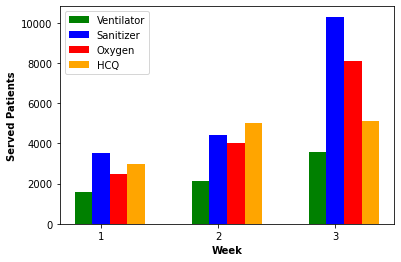

In [182]:
fig = plt.subplots(figsize =(6, 4)) 
plt.bar(br1,np.sum(x1.reshape(-1,3),axis=1), color ='green',  
        width = barWidth,label='Ventilator') 
plt.bar(br2,np.sum(x2.reshape(-1,3),axis=1), color ='blue',  
        width = barWidth,label='Sanitizer') 
plt.bar(br3,np.sum(x3.reshape(-1,3),axis=1), color ='red',  
        width = barWidth,label='Oxygen') 
plt.bar(br4,np.sum(x4.reshape(-1,3),axis=1), color ='orange',  
        width = barWidth,label='HCQ') 
# Adding Xticks  

plt.legend(loc='best')
plt.xlabel('Week', fontweight ='bold') 
plt.ylabel('Served Patients', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(x1[::3]))], 
           ['1', '2', '3']) 
plt.savefig('ServedPat.png',dpi=400)
plt.show()


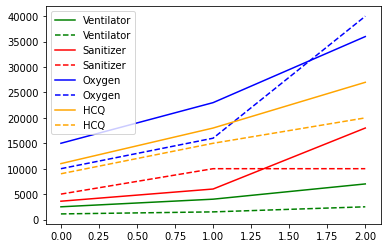

In [181]:
c=['g','r','b','orange']
com=['Ventilator','Sanitizer','Oxygen','HCQ']
for ix in range(4):
    plt.plot(np.sum(Dj,axis=1)[:,ix],label=com[ix],color=c[ix])
    plt.plot(np.sum(Si,axis=1)[:,ix],label=com[ix],linestyle='dashed',color=c[ix])
    
plt.legend()
plt.savefig('DemvsSup.png',dpi=400)

# for ix in range(4):
#     plt.plot(Dj[:,1,ix],color='green')
# for ix in range(4):
#     plt.plot(Dj[:,2,ix],color='b')